# ART for LNT production
We are analyzing a CRISPRa system that can quantitatively activate 3 orthogonal genes. Using this system, we have perturbed lacY, lgtA, and wbgO with 4 different levels each, leading to 64 different combinations. For each combination, we have measurements of lacto-N-tetraose (LNT) titer. 

Here, we use ART to model LNT production as a function of lacY, lgtA, and wbgO CRISPRa levels. We then use the trained model to generate predictions for combinations that improve LNT titer. 

In [1]:
import os
import sys
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append('../art')
sys.path.append('../notebooks')

import warning_utils
warning_utils.filter_end_user_warnings()

import pandas as pd
import numpy as np
import auxiliary_functions
import copy
from IPython.display import Image  # Used to display images

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from art.core import RecommendationEngine
import art.utility as utils

## Import non-formatted data for visualization

In [3]:
data_file = './data/LNTandLNTIIlibrarydata.xlsx'
data = pd.read_excel(data_file, usecols = 'A:F')
data = data.replace('OT', 0)
data = data.replace('Empty vector (no-pathway control)', 'ev')
column_dict = {'Strain name': 'strain', 'J306-lacY': 'lacY', 'J506-lgtA':'lgtA', 'J606-wbgO':'wbgO', '[LNT] (muM)':'LNT', '[LNTII] (muM)':'LNTII'}
data = data.rename(columns = column_dict)
data

,strain,lacY,lgtA,wbgO,LNT,LNTII
0,1,20,20,20,251.768996,3014.992089
1,2,20,20,18,1.691302,735.718908
2,3,20,20,17,49.086206,2781.075501
3,4,20,20,0,9.567430,2389.877054
4,5,20,18,20,113.827643,1791.706015
...,...,...,...,...,...,...
60,61,0,0,20,12.953911,52.117185
61,62,0,0,18,62.074754,96.140053
62,63,0,0,17,34.622906,88.805611
63,64,0,0,0,42.179468,99.156022


## Import EDD-formatted data for ART
ART operates on tall arrays like those produced from the experimental data depot (EDD).

In [4]:
data_edd = pd.read_excel('./data/LNT_Data_EDDFormat.xlsx')
data_edd = data_edd.rename(columns = {24: '24'})
data_edd[data_edd['Line Name'] == 'J356-432']

,Line Name,Type,24
6,J356-432,LNT I,23.682920
70,J356-432,LNT II,1955.235681
146,J356-432,lacY,20.000000
147,J356-432,lgtA,18.000000
148,J356-432,wbgO,17.000000


Replace '-' in line names with '_' so that cross validation can be used.

In [5]:
update_line_names = lambda x: x.replace('-', '_')
data_edd['Line Name'] = data_edd['Line Name'].apply(update_line_names)
data_edd

,Line Name,Type,24
0,J356_444,LNT I,251.768996
1,J356_443,LNT I,1.691302
2,J356_442,LNT I,49.086206
3,J356_441,LNT I,9.567430
4,J356_434,LNT I,113.827643
...,...,...,...
315,J356_112,lgtA,0.000000
316,J356_112,wbgO,17.000000
317,J356_111,lacY,0.000000
318,J356_111,lgtA,0.000000


## Set up ART parameters
Here, we use ART to generate 32 new recommendations. The relative recommendation distance (`rel_rec_distance`) parameter controls how similar recommendaitons can be to each other. Using a distance of 0.04 requires that new recommendations be approximately 1 nucleotide away from previous recommendations.

In [6]:
art_params = {
    'input_vars': ['lgtA', 'lacY', 'wbgO'],
    'response_vars': ['LNT I'],
    'objective': 'maximize',
    'threshold': 0.05,
    'num_recommendations': 32,
    'seed': 2,
    'output_dir': './output_morerecs_dist0_04/',
    'initial_cycle': False,
    'cross_val': True,
    'rel_rec_distance': 0.04
    
}
#Add bounds by making a dataframe
bounds = pd.DataFrame(columns = ['Variable', 'Min', 'Max'])
bounds['Variable'] = art_params['input_vars']
bounds['Min'] = 0
bounds['Max'] = 21
bounds = bounds.set_index('Variable')
bounds_file = f'{art_params["output_dir"]}bounds.csv'
bounds.to_csv(path_or_buf=bounds_file)
display(bounds)
art_params['bounds'] = utils.read_table(bounds_file)

,Min,Max
Variable,,
lgtA,0,21
lacY,0,21
wbgO,0,21


## Run ART

/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
Multiprocess sampling (2 chains in 2

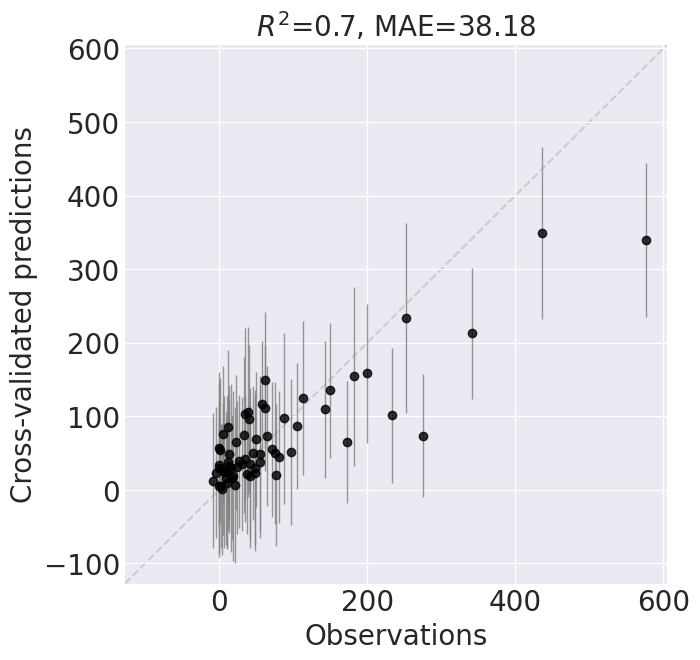

/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/

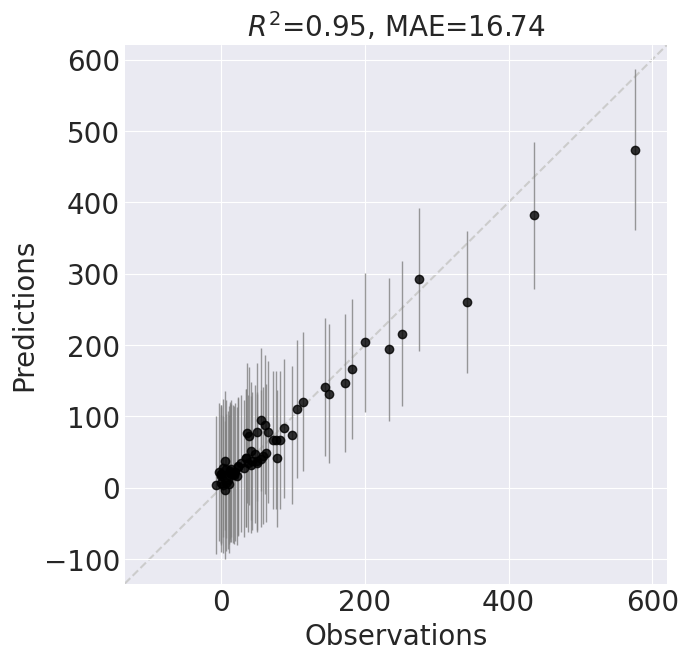

/code/lnt/../art/sandbox.py:1940: RuntimeWarning: divide by zero encountered in scalar divide
  (np.abs(new_rec[dimension] - point[dimension]) / np.abs(point[dimension]))
Sampling: [y]


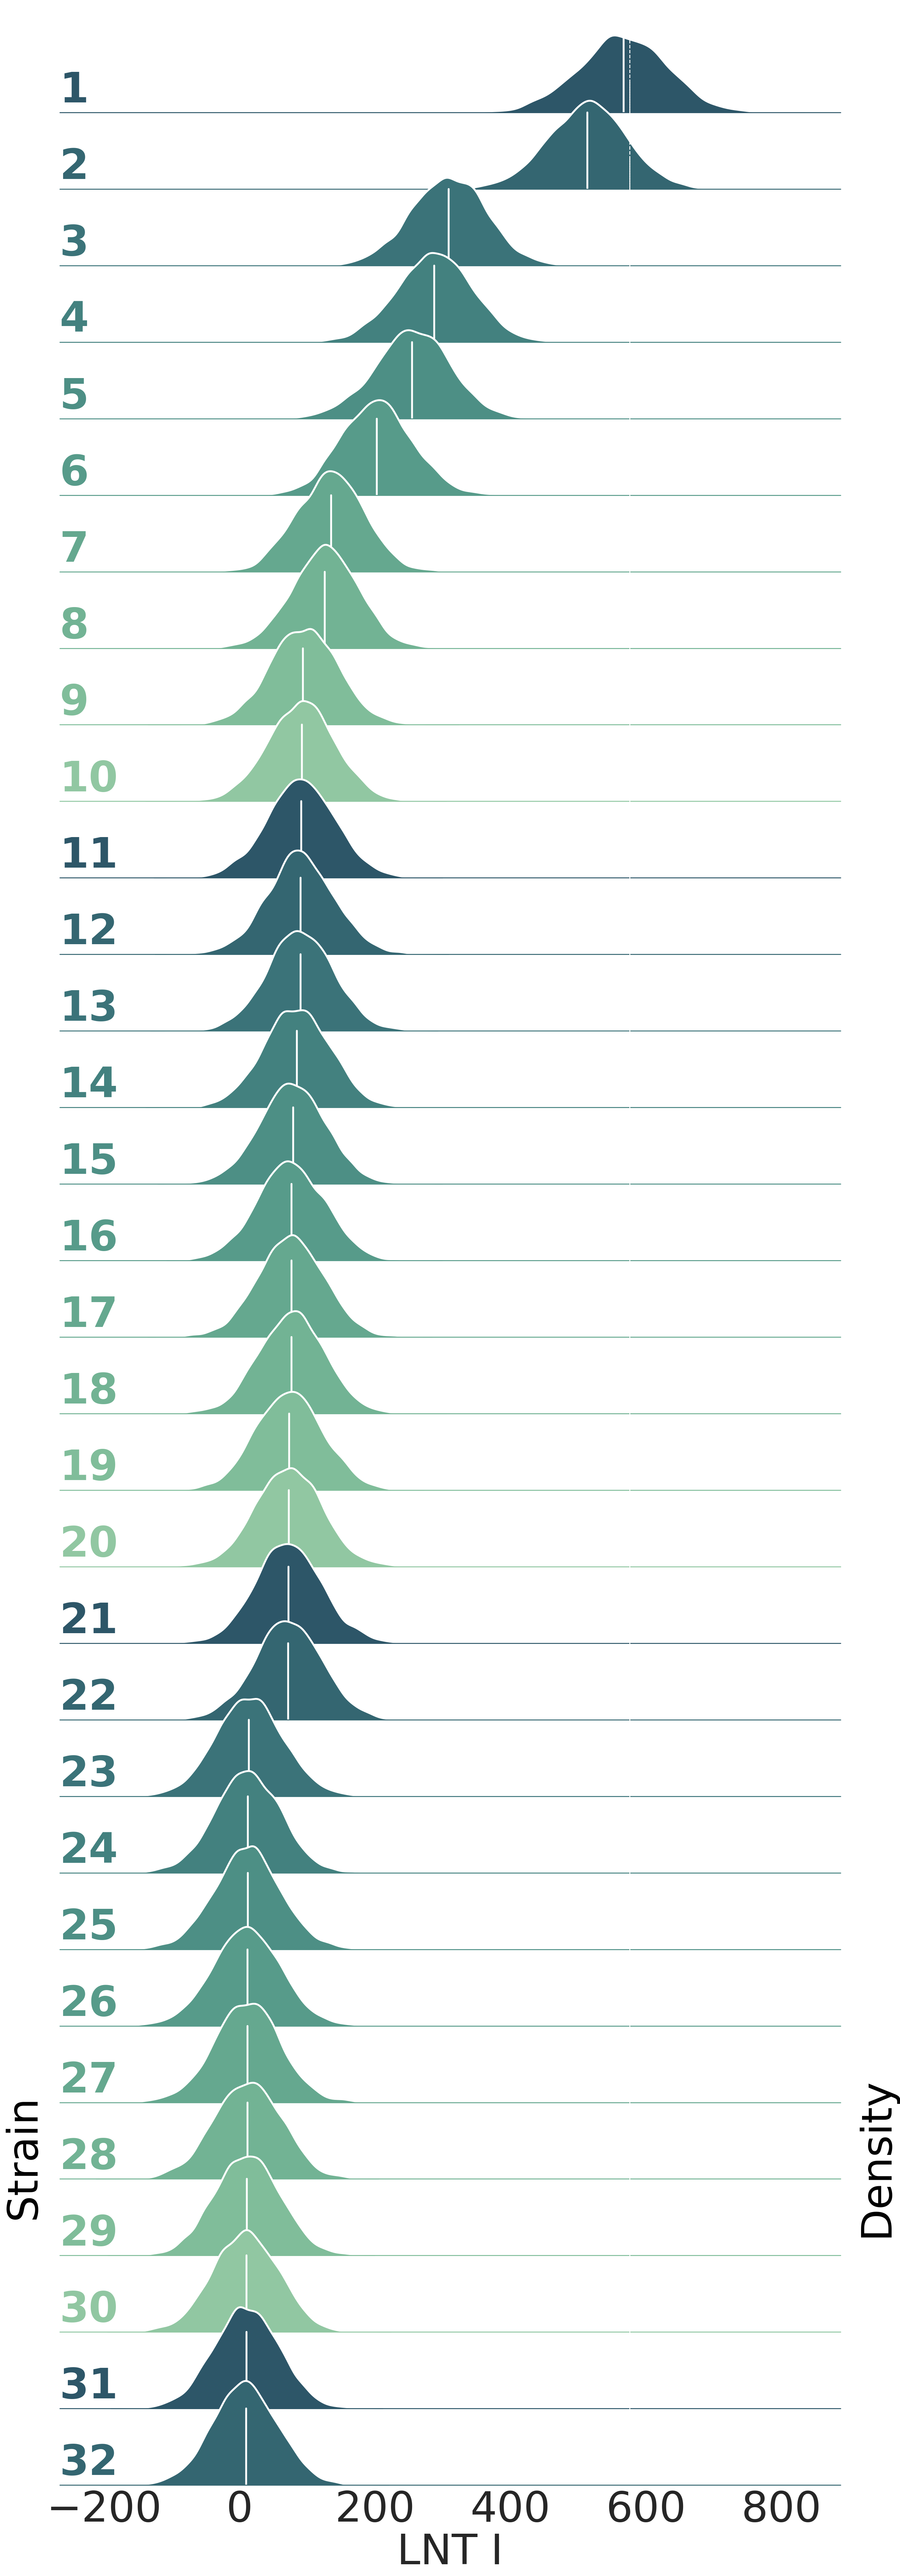

Sampling: [y]


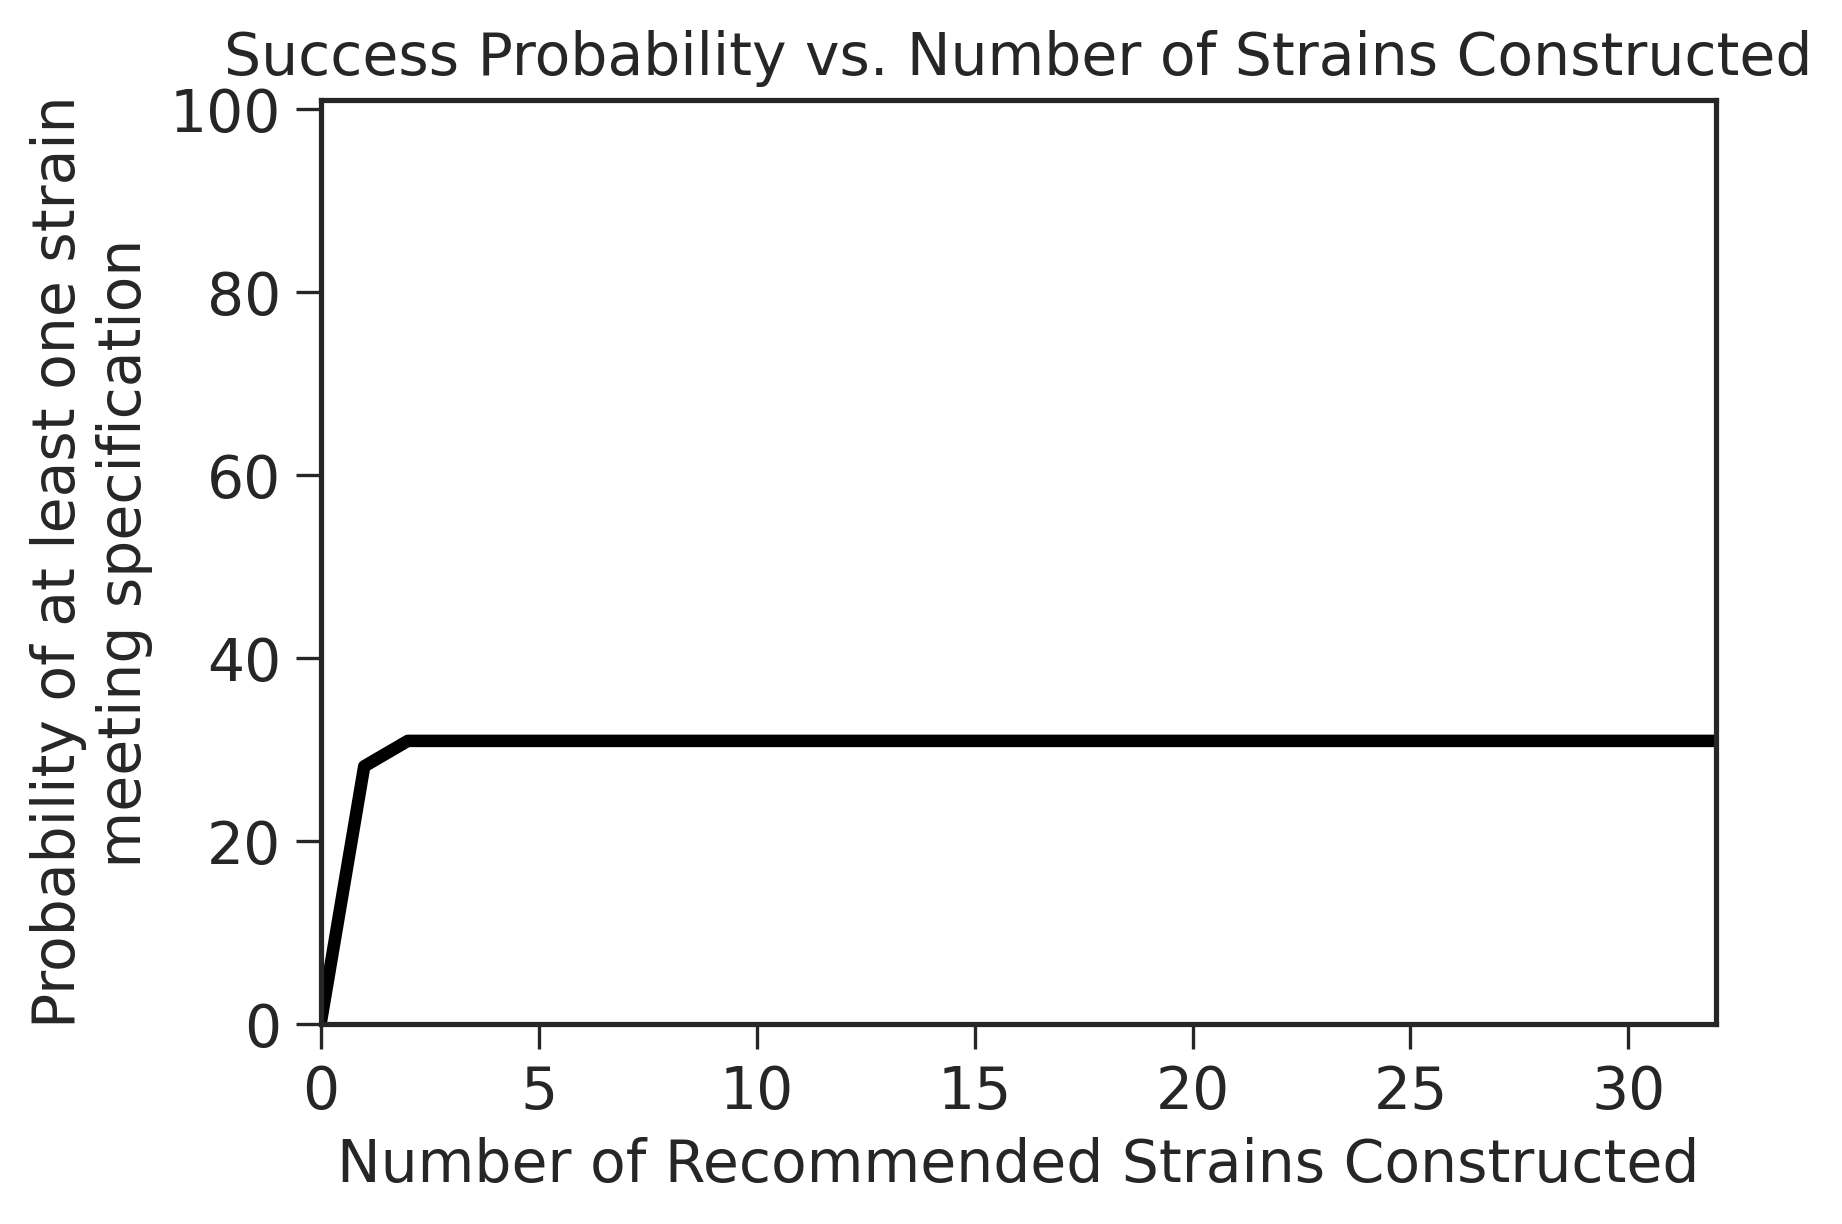

In [ ]:
art = RecommendationEngine(data_edd, **art_params)